In [45]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [46]:
path_prefix = '/home/avaz/courses/w23/winter-project/hgr_go1_ws/src/go1_hgr_ros2/ros2_hgr/'
dataset = path_prefix+'model/keypoint_classifier/keypoint.csv'
model_save_path = path_prefix+'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = path_prefix+'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [47]:
NUM_CLASSES = 8

# Dataset reading

In [48]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [49]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [52]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [54]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [55]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/45 [..............................] - ETA: 13s - loss: 2.0509 - accuracy: 0.1250
Epoch 1: saving model to /home/avaz/courses/w23/winter-project/hgr_go1_ws/src/go1_hgr_ros2/ros2_hgr/model/keypoint_classifier/keypoint_classifier.hdf5
45/45 [==============================] - 0s 3ms/step - loss: 2.0001 - accuracy: 0.1702 - val_loss: 1.8653 - val_accuracy: 0.1973
Epoch 2/1000
 1/45 [..............................] - ETA: 0s - loss: 1.9005 - accuracy: 0.2031
Epoch 2: saving model to /home/avaz/courses/w23/winter-project/hgr_go1_ws/src/go1_hgr_ros2/ros2_hgr/model/keypoint_classifier/keypoint_classifier.hdf5
45/45 [==============================] - 0s 2ms/step - loss: 1.8775 - accuracy: 0.2395 - val_loss: 1.7673 - val_accuracy: 0.2545
Epoch 3/1000
 1/45 [..............................] - ETA: 0s - loss: 1.8234 - accuracy: 0.3047
Epoch 3: saving model to /home/avaz/courses/w23/winter-project/hgr_go1_ws/src/go1_hgr_ros2/ros2_hgr/model/keypoint_classifier/keypoint_classifier.hdf5


In [56]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

15/15 [==============================] - 0s 796us/step - loss: 0.4490 - accuracy: 0.9182


In [57]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [58]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 32ms/step
[4.0956870e-01 1.9145916e-01 3.7056342e-01 8.1829837e-04 2.3483487e-03
 2.5084829e-02 1.2884707e-04 2.8382225e-05]
0


# Confusion matrix

60/60 [==============================] - 0s 601us/step


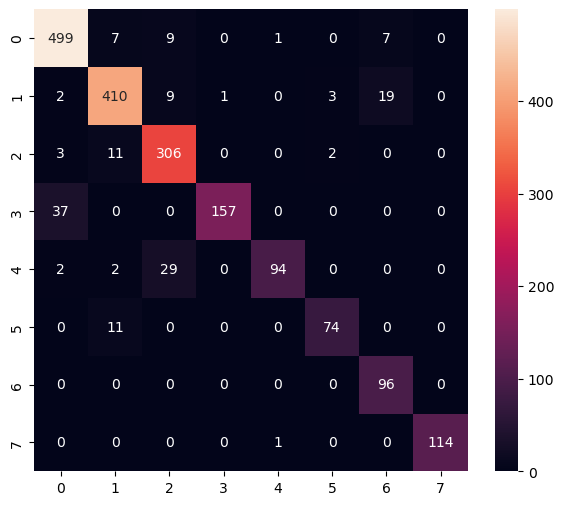

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       523
           1       0.93      0.92      0.93       444
           2       0.87      0.95      0.91       322
           3       0.99      0.81      0.89       194
           4       0.98      0.74      0.84       127
           5       0.94      0.87      0.90        85
           6       0.79      1.00      0.88        96
           7       1.00      0.99      1.00       115

    accuracy                           0.92      1906
   macro avg       0.93      0.90      0.91      1906
weighted avg       0.92      0.92      0.92      1906



In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [60]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [61]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpmwd711zj/assets


INFO:tensorflow:Assets written to: /tmp/tmpmwd711zj/assets
2023-02-02 14:04:20.813421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-02 14:04:20.813443: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-02 14:04:20.813560: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmwd711zj
2023-02-02 14:04:20.814506: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-02 14:04:20.814525: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmwd711zj
2023-02-02 14:04:20.817730: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-02 14:04:20.844987: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmwd711zj
2023-02-02 14:04:20.851768: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6748

# Inference test

In [62]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [63]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [64]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [65]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 630 µs, sys: 37 µs, total: 667 µs
Wall time: 558 µs


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.0956876e-01 1.9145912e-01 3.7056339e-01 8.1829884e-04 2.3483494e-03
 2.5084833e-02 1.2884710e-04 2.8382225e-05]
0
